# Домашняя работа

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Построить случайный лес, вывести важность признаков
3. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
4. В качестве решения: Jupyter notebook с кодом, комментариями и графиками

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from jupyterthemes import jtplot
from sklearn.metrics import auc, roc_curve, roc_auc_score
%matplotlib inline
jtplot.style()

In [74]:
data = pd.read_csv('homeworkdata/train.csv')
# data_test = pd.read_csv('homeworkdata/test.csv')

In [92]:
data_test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [116]:
#data.info()

In [100]:
import numpy as np
from sklearn.model_selection import train_test_split

X = data.loc[:, data.columns != 'SalePrice']
y = data.loc[:, data.columns == 'SalePrice']

# X_train, X_test, y_train, y_test = train_test_split(
# X, y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [101]:
#Находим категориальные признаки
cat_feat = list(X_train.dtypes[X_train.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
# data[cat_feat] = data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in X_train if f not in (cat_feat + ['ID', 'Id', 'target'])]

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = X_train[cat_feat].nunique()
#print(cat_nunique)

#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 30 уникальных значений
cat_feat = list(cat_nunique[cat_nunique < 30].index)
# cat_feat
# num_feat
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(X_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(X_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]

# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([X_train[num_feat].fillna(-999),
                     dummy_train], axis=1)
X_test = pd.concat([X_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

In [102]:
X_train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Condition1_RRAe,GarageType_Basment,MiscFeature_Othr,GarageQual_TA,HeatingQC_Gd,Foundation_Slab,Neighborhood_Veenker,BldgType_Twnhs,Exterior2nd_ImStucc,PoolQC_Gd
615,85,80.0,8800,6,7,1963,1963,156.0,763,0,...,0,0,0,1,0,0,0,0,0,0
613,20,70.0,8402,5,5,2007,2007,0.0,206,0,...,0,0,0,0,0,0,0,0,0,0
1303,20,73.0,8688,7,5,2005,2005,228.0,0,0,...,0,0,0,1,0,0,0,0,0,0
486,20,79.0,10289,5,7,1965,1965,168.0,836,0,...,0,0,0,1,0,0,0,0,0,0
561,20,77.0,10010,5,5,1974,1975,0.0,1071,123,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,20,78.0,9317,6,5,2006,2006,0.0,24,0,...,0,0,0,1,1,0,0,0,0,0
1130,50,65.0,7804,4,3,1928,1950,0.0,622,0,...,0,0,0,1,0,0,0,0,0,0
1294,20,60.0,8172,5,7,1955,1990,0.0,167,0,...,0,0,0,1,0,0,0,0,0,0
860,50,55.0,7642,7,8,1918,1998,0.0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [103]:
from sklearn.ensemble import RandomForestRegressor

regr_rf = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
# regr_rf.fit(X_train, y_train)  
regr_rf

RandomForestRegressor(max_depth=5, max_features=0.5, min_samples_leaf=20,
                      n_estimators=10, n_jobs=-1)

In [104]:
regr_rf.fit(X_train, y_train)  

<ipython-input-104-342ccc05023d>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr_rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=5, max_features=0.5, min_samples_leaf=20,
                      n_estimators=10, n_jobs=-1)

In [105]:
def show_auc(y, y_pred, plot_label='', prin=True):    
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

In [106]:
y_pred_train = regr_rf.predict(X_train)
y_pred_test = regr_rf.predict(X_test)

In [107]:
y_train

,SalePrice
615,137500
613,147000
1303,232000
486,156000
561,170000
...,...
1095,176432
1130,135000
1294,115000
860,189950


In [108]:
# ?regr_rf.score
# print('Train:')
# show_auc(y_train, y_pred_train, 'train')
print('Train:', regr_rf.score(X_train, y_train))
print('Test:', regr_rf.score(X_test, y_test))

Train: 0.8372782122490293
Test: 0.7971824548624268


In [118]:
import time
import numpy as np

start_time = time.time()
importances = regr_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr_rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.012 seconds


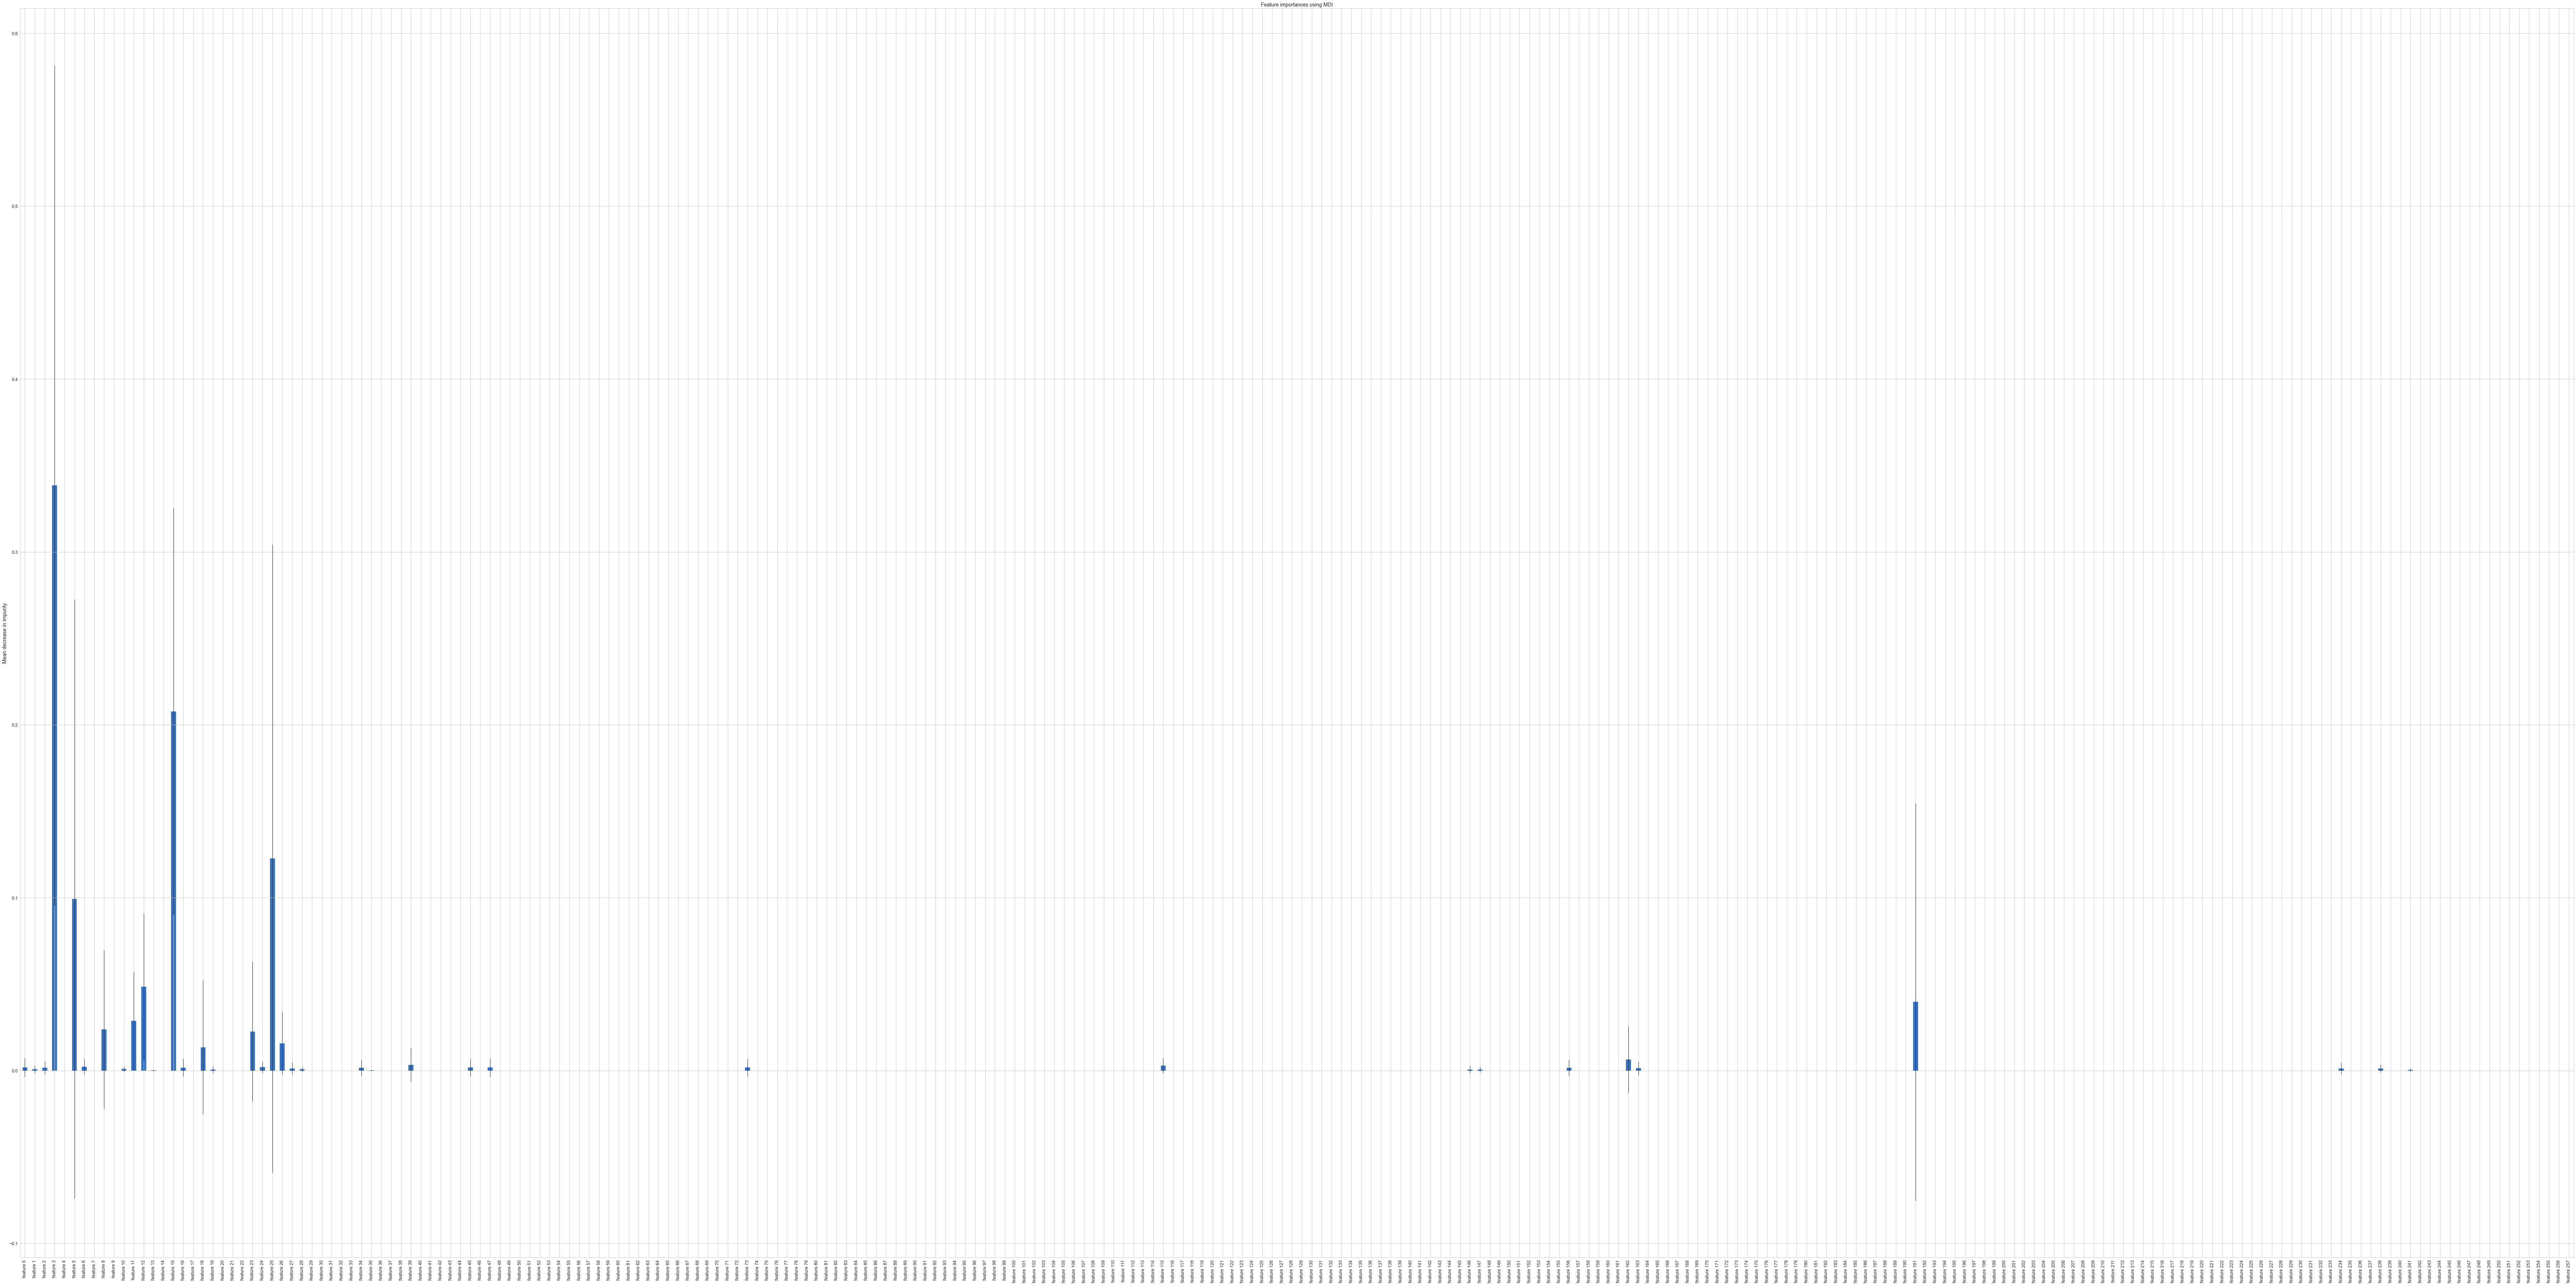

In [135]:
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
# feature_names
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.rcParams["figure.figsize"] = (100, 200)
plt.show()

In [152]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVR

In [159]:
reg = StackingRegressor(
    [
        ('lr', LinearRegression()),
        ('en', ElasticNet()),
        ('nr', KNeighborsRegressor())
    ],
LinearSVR())

In [161]:
reg.fit(X_train, y_train).score(X_test, y_test)

C:\Users\vanio\develop\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\vanio\develop\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 550130525452.9448, tolerance: 566931384.7288021
  model = cd_fast.enet_coordinate_descent(
C:\Users\vanio\develop\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 418493127946.5294, tolerance: 453499063.6560846
  model = cd_fast.enet_coordinate_descent(
C:\Users\vanio\develop\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Obj

0.7874579879506713

In [163]:
pd.Series(reg.final_estimator_.coef_.flatten(), index=reg.named_estimators_.keys()).plot(kind='barh')

<AxesSubplot:>